### Библиотеки/пакеты, которые понадобятся

In [1]:
# pip install wordcloud
# pip install gensim
# nltk.download('stopwords')
# nltk.download('wordnet')
# pip install pymorphy2
# pip install lightgbm
# pip install navec
# pip install wget

### Импортируем необходимые библиотеки

In [2]:
import numpy as np 
import pandas as pd
import re, string, unicodedata
import os
import wget
from os import path
import random
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import pymorphy2

from navec import Navec

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
import gensim

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, LSTM, Conv1D, MaxPool1D, GlobalAveragePooling1D

from keras.models import Model

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import f1_score

In [4]:
from keras.models import load_model

#### Загрузим данные и проведем EDA

In [5]:
random.seed(42)
np.random.seed(42)

In [6]:
df = pd.read_csv("train.tsv", sep = '\t')

In [7]:
df.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


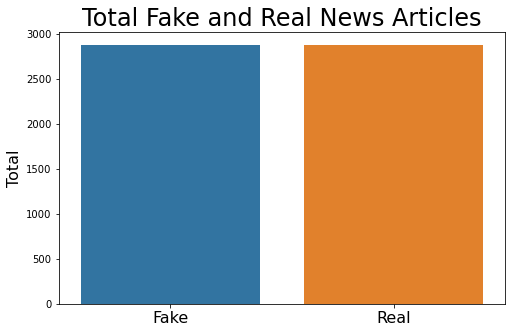

In [8]:
plt.figure(figsize=(8,5))

sns.countplot(x=df.is_fake)
plt.title('Total Fake and Real News Articles', fontsize=24)
plt.ylabel('Total', fontsize=16)
plt.xlabel('')
plt.xticks([0, 1], ['Fake', 'Real'], fontsize=16)

plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


Видим, что:
1. В данных нет пропусков.
2. Количество данных практически одинаково для каждого из двух классов, т.е. данные сбалансированные.

Таким образом, каких-то манипуляций с данными по типу заполнения пропусков, сэмплирования проводить не нужно и можно приступить к их обработке с точки зрения работы с естественным языком.

#### Что нужно сделать:

1. Удалим стоп-слова (предлоги, междометья...), которые не привнесут в модели новой информации, и будут мешать.
2. Также удаляются ссылки/скобки/пунктуация, всё то, что также будет лишь мешать модели.
3. Со словами можно провести ряд манипуляций, рассмотрим их

    - Стемминг - нормализация слов, путем отбрасывания окончаний. Для русского языка этот метод работает плохо (для английского в разы лучше - может повысить качество модели).
    - Лемматизация - приведение слов к начальной морфологической форме. Существуют специальные библиотеки, для русского языка в том числе -> работает гораздо лучше, чем стемминг, но медленнее. Буду его использовать.

In [10]:
russian_stopwords = stopwords.words("russian")
# russian_stopwords

In [11]:
morph = pymorphy2.MorphAnalyzer()

In [12]:
# morph.parse('стали')
# Так как тегов для слов у нас нет, то лемматизатор может вернуть массив со всеми "вхождениями" слова в своём словаре, т.е.
# может вернуть разные части речи. Будем брать первое из списка.

In [13]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# def remove_between_square_brackets(text):
#     return re.sub('\[[^]]*\]', '', text)

def replace(text):
    text = text.replace('«', '')
    text = text.replace('»', '')
    text = text.replace('-', ' ')
    text = text.replace('-', ' ')
    text = text.replace(' 0 ', ' ')
    text = text.replace(' 1 ', ' ')
    text = text.replace(' 2 ', ' ')
    text = text.replace(' 3 ', ' ')
    text = text.replace(' 4 ', ' ')
    text = text.replace(' 5 ', ' ')
    text = text.replace(' 6 ', ' ')
    text = text.replace(' 7 ', ' ')
    text = text.replace(' 8 ', ' ')
    text = text.replace(' 9 ', ' ')
    text = text.replace('&', ' ')
    return text

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if len(i) > 2:
            if i.strip().lower() not in russian_stopwords:
    #             final_text.append(i.strip())
                final_text.append(morph.parse(i)[0].normal_form.strip())
    return " ".join(final_text)

def lower_words(text):
    return str(text).lower()

def clean_text(text):
    text = lower_words(text)
    text = replace(text)
    text = strip_html(text)
#     text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_stopwords(text)
    return text

In [14]:
df['changed_title'] = df['title'].apply(clean_text)

In [15]:
df.head(2)

,title,is_fake,changed_title
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутина прийти счёт вмешатель...
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин назвать езда встречка житейский ...


In [16]:
df_train = df[['changed_title', 'is_fake']].copy(deep=True)

In [17]:
df_train.to_csv('df.csv')

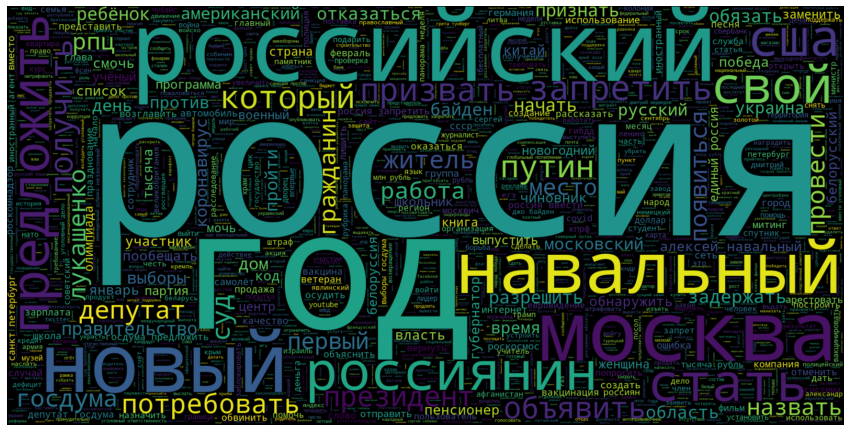

In [17]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words=2000 , width=1600 ,
               height=800 , stopwords=russian_stopwords).generate(" ".join(df[df.is_fake == 1].changed_title))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

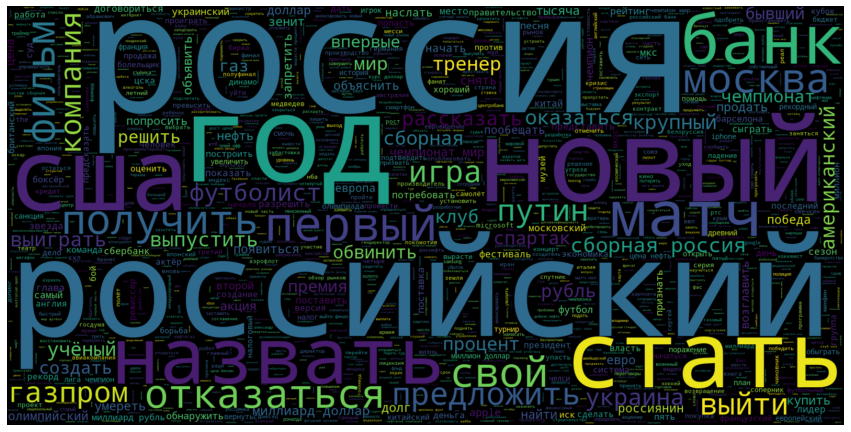

In [18]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words=2000 , width=1600 ,
               height=800 , stopwords=russian_stopwords).generate(" ".join(df[df.is_fake == 0].changed_title))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [19]:
df['word_length'] = df['title'].apply(lambda x: len(x.split()))

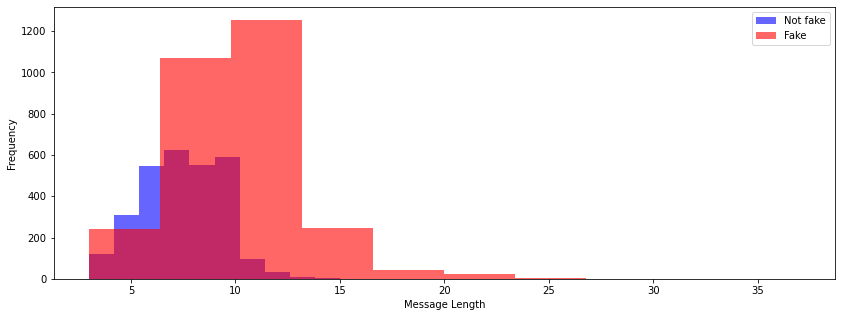

In [24]:
plt.figure(figsize=(14, 5))
df[df.is_fake == 0].word_length.plot(kind='hist', color='blue', label='Not fake', alpha=0.6)
df[df.is_fake == 1].word_length.plot(kind='hist', color='red', label='Fake', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")
plt.show()

Создал колонку количество слов в предложении. Сгруппировали по "фейковести", заметно, что фейковые новости в среднем длиннее, чем настоящие. Но опять же это информации просто в качестве исследования/наблюдения и при обучении моделей никак использоваться не будет.

In [25]:
print(df['title'][0], '\n', df['changed_title'][0], '\n', 'Это фейк?: ', df.is_fake[0])

Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы 
 москвич владимир клутина прийти счёт вмешательство американский выборы 
 Это фейк?:  1


In [26]:
print(df['title'][50], '\n', df['changed_title'][50], '\n', 'Это фейк?: ', df.is_fake[50])

Fox начала работу над экранизацией Вольтрона 
 fox начало работа экранизация вольтрон 
 Это фейк?:  0


Вывел несколько строк для сравнения. Посомотреть как отработали функции. Понятно, что всё не просмотришь, но тот результат, который видим, вполне устраивает.

Итак, данные достаточно хорошо уже предобработаны (у нас нет пропущенных данных, несбалансированных классов, специфичного "мусора" (хотя как оказалось впоследствии немного всё же есть и я его удалил) в данных, требующего удаления), поэтому каких-то дополнительных действий (разве что по большому счету удаления стоп слов) по обработке тетска оказалось не очень много.

### Пробуем первые модели

Подготовка данных завершена. Попробуем обучить простые модели.

In [27]:
df.head()

,title,is_fake,changed_title,word_length
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,москвич владимир клутина прийти счёт вмешатель...,10
1,Агент Кокорина назвал езду по встречке житейск...,0,агент кокорин назвать езда встречка житейский ...,8
2,Госдума рассмотрит возможность введения секрет...,1,госдума рассмотреть возможность введение секре...,8
3,ФАС заблокировала поставку скоростных трамваев...,0,фас заблокировать поставка скоростной трамвай ...,7
4,Против Навального завели дело о недоносительст...,1,против навальный завести дело недоносительство...,8


In [28]:
X = df['changed_title']
Y = df['is_fake']

In [29]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit_transform(X)
freq_term_matrix = count_vectorizer.transform(X)
tfidf = TfidfTransformer()
# tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.fit_transform(freq_term_matrix)

In [30]:
X_features = pd.DataFrame(tf_idf_matrix.toarray())
X_features.head()

,0,1,2,3,4,5,6,7,8,9,...,11271,11272,11273,11274,11275,11276,11277,11278,11279,11280
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
print(df['title'][0], '\n', df['changed_title'][0])

Москвичу Владимиру Клутину пришёл счёт за вмешательство в американские выборы 
 москвич владимир клутина прийти счёт вмешательство американский выборы


In [32]:
print(tf_idf_matrix[0])

  (0, 9629)	0.333039293478496
  (0, 7718)	0.3992595056645968
  (0, 5506)	0.32145126901876325
  (0, 4314)	0.44471038072448127
  (0, 2229)	0.2812266037925351
  (0, 1976)	0.42459804811136714
  (0, 1961)	0.3071813419343427
  (0, 1014)	0.2735802498073818


In [33]:
list(count_vectorizer.vocabulary_.keys())[list(count_vectorizer.vocabulary_.values()).index(9629)]

'счёт'

In [34]:
count_list = tf_idf_matrix.toarray().sum(axis=0)
word_list = count_vectorizer.get_feature_names()

In [35]:
word_freq = pd.DataFrame(count_list, index=word_list, columns=['Freq'])
word_freq.sort_values(by='Freq', ascending=False).head(10)

,Freq
россия,101.039309
российский,61.732429
год,50.471204
новый,50.450202
москва,38.494366
запретить,37.827997
сша,37.782475
предложить,37.708265
стать,35.961655
госдума,31.030216


In [36]:
word_freq.sort_values(by='Freq', ascending=False).tail(10)

,Freq
хрущёва,0.254244
множество,0.254244
первого,0.254244
отвечать,0.218431
тебе,0.218431
стоит,0.218431
государям,0.218431
нам,0.218431
лая,0.218431
обращаться,0.218431


In [37]:
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y, shuffle=True, random_state=42)

Итак, с помощью CountVectorizer мы создали словарь из переданного текста с последующим его представлением в виде разреженной матрицы. Но некоторые слова могут встречаться часто и не нести особой информации (вообще мы постарались удалить такие стоп слова), но в тот список входило не всё и нужно оценить "полезность" слов. Для этого используем TfidfTransformer, которая вернет из простой матрицы частот, взвешенную матрицу, где наиболее частые слова имеют меньший вес. Такую матрицу можно подавать уже на обучение классификатору.

In [38]:
# print(X_train)

In [39]:
# print(tf_idf_matrix)

### 1. Логистическая регрессия

In [40]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Accuracy = logreg.score(X_test, y_test)
Accuracy

0.8326388888888889

In [41]:
y_pred = logreg.predict(X_test)
f1_score(y_test, y_pred, average='binary')

0.8325225851285615

### 2. Байесовский классификатор

In [42]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
Accuracy = NB.score(X_test, y_test)
Accuracy

0.8472222222222222

In [43]:
# NB.intercept_

In [44]:
y_pred_nb = NB.predict(X_test)
f1_score(y_test, y_pred_nb, average='binary')

0.8509485094850948

### 3. Дерево решений

In [45]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
Accuracy = clf.score(X_test, y_test)
Accuracy

0.76875

In [46]:
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average='binary')

0.758169934640523

### 4. Градиентный бустинг

In [37]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
Accuracy = gbc.score(X_test, y_test)
Accuracy

0.7263888888888889

In [38]:
y_pred = gbc.predict(X_test)
f1_score(y_test, y_pred, average='binary')

0.6672297297297297

### 5. SVM

In [39]:
svc = svm.SVC()
svc.fit(X_train, y_train)
Accuracy = svc.score(X_test, y_test)
Accuracy

0.8375

In [40]:
y_pred = svc.predict(X_test)
f1_score(y_test, y_pred, average='binary')

0.8379501385041552

### 6. SGB

In [39]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
Accuracy = sgd.score(X_test, y_test)
Accuracy

0.8298611111111112

In [40]:
y_pred = sgd.predict(X_test)
f1_score(y_test, y_pred, average='binary')

0.8287910552061495

Поолучилось некое полотно из простых моделей и что вообще с этим делать.

- Во-первых, хочу отметить, что подбор параметров у моделей (из этих 6), которые показали лучшее качество не дал особо никакого прироста в качестве, т.е. стандартные дефолтные параметры показывают лучшее качество.

- Во-вторых, интересно заметить какой разброс в качестве между разными моделями. Ну, дерево решений понятно, игрушечный алгоритм, качество которого используается скорее для контраста и сравнения. Качество моделей с бустингом также вполне логичны, градиентный спуск хорош в других задачах.

- Что также интерсно отметить, так это качество байесовского классификатора, который из коробки показывает 85%, обучаясь при этом "секунду" (очень быстро). Не зря долгое время даже в проде при классификации использовался именно он.

- В принципе каких-то ещё интересных наблюдений или выводов сделать, наверное, не могу. Будем использовать качество байесовского классификатора пока как лучшее и пытаться его улучшить.

### Более сложные модели

Попробуем теперь обучить более сложные, чем классические классификаторы, модели - нейросети и сравнить результаты.

Одним из распространенных способов является передача в нейронную сеть уже созданных эмбедингов, чтобы сеть в процессе обучения не вычисляла их сама. Для русского языка также есть уже созданный словарь - navec. Кроме того можно самостоятельно создать эти эмбединги и также передать в модель.

In [15]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Embedding,Bidirectional
import tensorflow
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import Dropout

In [16]:
y = df['is_fake']

Проведем манипуляции с данными, необходимые для создания эмбедингов самостоятельно.

In [17]:
X = [d.split() for d in df['changed_title'].to_list()]

In [18]:
print(X[0])

['москвич', 'владимир', 'клутина', 'прийти', 'счёт', 'вмешательство', 'американский', 'выборы']


In [19]:
df['changed_title'].to_list()[0].split()

['москвич',
 'владимир',
 'клутина',
 'прийти',
 'счёт',
 'вмешательство',
 'американский',
 'выборы']

In [20]:
# df.word_length.min()

In [21]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=4, min_count=1)

In [22]:
w2v_model

In [23]:
w2v_model.wv['россия'][:5]

array([-0.00286583,  0.01855271,  0.01894099,  0.01110713, -0.00870887],
      dtype=float32)

In [24]:
w2v_model.wv['российский'][:5]

array([-0.01012055,  0.01967424,  0.01602906,  0.00700564,  0.00969753],
      dtype=float32)

In [25]:
w2v_model.wv.most_similar('путин')

[('свой', 0.7485427856445312),
 ('стать', 0.713552713394165),
 ('российский', 0.7027251720428467),
 ('новый', 0.6916593313217163),
 ('россиянин', 0.6781421899795532),
 ('год', 0.6747668385505676),
 ('россия', 0.6744328737258911),
 ('сша', 0.6660800576210022),
 ('суд', 0.6403293609619141),
 ('получить', 0.635830283164978)]

In [26]:
w2v_model.wv.most_similar('россия')

[('стать', 0.8283053040504456),
 ('россиянин', 0.8024221658706665),
 ('российский', 0.7982714772224426),
 ('получить', 0.7973330616950989),
 ('год', 0.7965943217277527),
 ('предложить', 0.7920796275138855),
 ('новый', 0.7856929898262024),
 ('назвать', 0.7824666500091553),
 ('свой', 0.7686275839805603),
 ('москва', 0.7570484280586243)]

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [28]:
X = tokenizer.texts_to_sequences(X)
# преобразуем каждое предложение к определенной длине

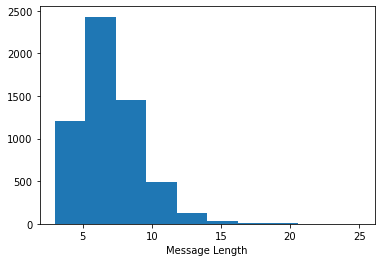

In [29]:
plt.hist([len(x) for x in X], bins=10)
plt.xlabel("Message Length")
plt.show()

In [30]:
nos = np.array([len(x) for x in X])
len(nos[nos>13])

47

In [31]:
maxlen = 13
X = pad_sequences(X, maxlen=maxlen)

In [32]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

Загрузим существующее эмбединги из библиотеки Navec.

In [33]:
weight_matrix = np.zeros((vocab_size, 300))

In [34]:
# wget.download('https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar')

In [35]:
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)

In [36]:
navec.get('российский')[:10]

array([ 0.01543992, -0.15983614,  0.61529845, -0.02604746, -0.00932499,
        0.65926665, -0.24904737, -0.23320763,  0.42050472,  0.423274  ],
      dtype=float32)

In [37]:
hits, misses = 0, 0
missing_words = []
for word, i in vocab.items():
    embedding_vector = navec.get(word)
    if embedding_vector is not None:
        weight_matrix[i] = embedding_vector
        hits += 1
    else:
        missing_words.append(word)
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 8956 words (2610 misses)


In [38]:
missing_words[:5]

['коронавирус', '100', 'роскосмос', 'анонсировать', 'роскомнадзор']

In [39]:
missing_words[-25:-20]

['мужчину,', 'невыплата', 'стерлигова,', 'ефремова,', 'кафельников']

In [40]:
# '—' == '–'

In [41]:
# missing_words[600:]

Видим, что четверть слов не рапозналась, т.е. в словаре эмбедингов таковых нет. Что собственно логично, в нераспознанных много фамилий (в том числе там цифры, неправильно написанные слова, ошибки и т.д.). И тут я оказался удивлён, на самом деле, потому что мне казалось, что фамилии должны быть очень важны для классификации. И без них качество сильно (относительно даже байесовского классификатора, качество которого пока лучшее) просядет. Однако, относительно маленькая модель показывает качество +- сопоставимое. Наверное, роль сыграли как раз ошибки/цифры и всякий такой мусор, который не убрал на этапе обработки текста. Но в то же время, кроме фамилий, там есть и обычные слова: прилагательные, глаголы.

Получим собственные эмбединги.

In [42]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    
    return weight_matrix

In [43]:
embedding_vectors = get_weight_matrix(w2v_model)
assert (embedding_vectors.shape[0] == len(tokenizer.word_index) + 1)

In [44]:
vocab_size

11567

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### 1. Попробуем очень простую модель, один слой LSTM. Эмбединги свои.

In [49]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=DIM,
                    weights=[embedding_vectors],
                    input_length=maxlen,
                    trainable=False))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 100)           1156700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,173,757
Trainable params: 17,057
Non-trainable params: 1,156,700
_________________________________________________________________


In [51]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=3)

Epoch 1/3
108/108 [==============================] - 3s 23ms/step - loss: 0.6906 - acc: 0.5423 - val_loss: 0.6753 - val_acc: 0.5613
Epoch 2/3
108/108 [==============================] - 1s 7ms/step - loss: 0.6420 - acc: 0.6268 - val_loss: 0.6201 - val_acc: 0.6586
Epoch 3/3
108/108 [==============================] - 1s 6ms/step - loss: 0.6208 - acc: 0.6540 - val_loss: 0.6055 - val_acc: 0.6887


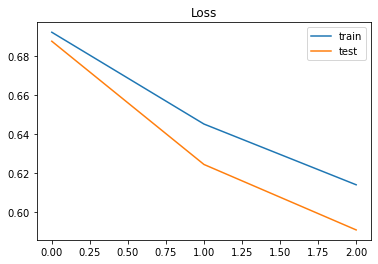

In [50]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [52]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [53]:
accuracy_score(y_test, y_pred)

0.7104166666666667

In [54]:
f1_score(y_test, y_pred, average='binary')

0.6885735623599701

#### Та же модель, только эмбединги navec.

In [54]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=300,
                    weights=[weight_matrix],
                    input_length=maxlen,
                    trainable=False))

model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 300)           3470100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,512,757
Trainable params: 42,657
Non-trainable params: 3,470,100
_________________________________________________________________


In [56]:
X_train.shape

(4318, 13)

In [57]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=3)

Epoch 1/3
108/108 [==============================] - 1s 12ms/step - loss: 0.5102 - acc: 0.7533 - val_loss: 0.3974 - val_acc: 0.8137
Epoch 2/3
108/108 [==============================] - 1s 7ms/step - loss: 0.3457 - acc: 0.8483 - val_loss: 0.3646 - val_acc: 0.8368
Epoch 3/3
108/108 [==============================] - 1s 7ms/step - loss: 0.2915 - acc: 0.8749 - val_loss: 0.3785 - val_acc: 0.8310


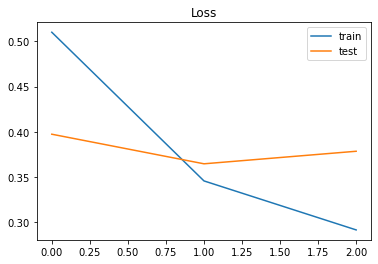

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [59]:
# model.predict(X_test)

In [60]:
y_pred = (model.predict(X_test) >= 0.5).astype(int)

In [61]:
accuracy_score(y_test, y_pred)

0.8534722222222222

In [62]:
f1_score(y_test, y_pred, average='binary')

0.8601722995361167

#### Попробуем ту же архитектуру, но эмбединги будем обучать.

In [63]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    output_dim=DIM,
                    input_length=maxlen))

model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 13, 100)           1156700   
_________________________________________________________________
dropout (Dropout)            (None, 13, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,173,757
Trainable params: 1,173,757
Non-trainable params: 0
_________________________________________________________________


In [65]:
history = model.fit(X_train, y_train, validation_split=0.15, epochs=3)

Epoch 1/3
115/115 [==============================] - 3s 23ms/step - loss: 0.5753 - accuracy: 0.7188 - val_loss: 0.3913 - val_accuracy: 0.8565
Epoch 2/3
115/115 [==============================] - 2s 16ms/step - loss: 0.2228 - accuracy: 0.9158 - val_loss: 0.3276 - val_accuracy: 0.8657
Epoch 3/3
115/115 [==============================] - 2s 17ms/step - loss: 0.0671 - accuracy: 0.9785 - val_loss: 0.3538 - val_accuracy: 0.8704


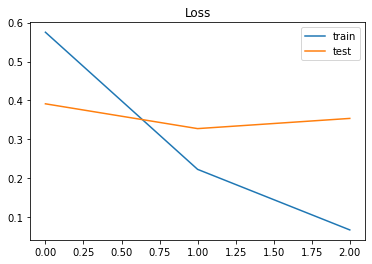

In [66]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [67]:
y_pred_nn = (model.predict(X_test) >= 0.5).astype(int)
accuracy_score(y_test, y_pred_nn)

0.8708333333333333

In [68]:
f1_score(y_test, y_pred_nn, average='binary')

0.8701117318435756

In [69]:
# model.save('model.h5')

Видим, что:

- Эмбединги navec гораздо лучше.
- Однако, качество модели, у которой эмбединги обучали всё равно лучше, хоть и на ~2%
- Модели очень быстро переобучаются, буквально вторая эпоха и всё...

In [515]:
model = Sequential()
model.add(Embedding(vocab_size, 
                    output_dim=DIM,
                    input_length=maxlen))

model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(25, return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(200,return_sequences=True)))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(300,return_sequences=True)))
model.add(Dropout(0.6))
model.add(Bidirectional(LSTM(15, return_sequences=False)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

In [516]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 13, 100)           1156700   
_________________________________________________________________
dropout_27 (Dropout)         (None, 13, 100)           0         
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 13, 50)            25200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 13, 50)            0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 30)                7920      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 31        
Total params: 1,189,851
Trainable params: 1,189,851
Non-trainable params: 0
___________________________________________

In [517]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=3)

Epoch 1/3
122/122 [==============================] - 5s 44ms/step - loss: 0.5582 - accuracy: 0.6966 - val_loss: 0.3424 - val_accuracy: 0.8773
Epoch 2/3
122/122 [==============================] - 3s 25ms/step - loss: 0.2448 - accuracy: 0.9084 - val_loss: 0.3005 - val_accuracy: 0.8727
Epoch 3/3
122/122 [==============================] - 3s 23ms/step - loss: 0.1059 - accuracy: 0.9681 - val_loss: 0.3329 - val_accuracy: 0.8681


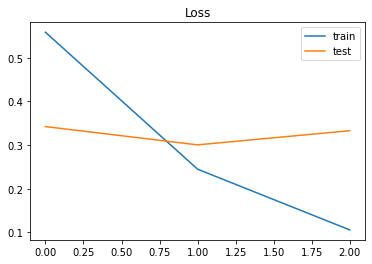

In [518]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [519]:
## y_pred_nn = (model.predict(X_test) >= 0.5).astype(int)
accuracy_score(y_test, y_pred_nn)

0.8479166666666667

In [520]:
f1_score(y_test, y_pred_nn, average='binary')

0.8582524271844661

Пробуя модели сложнее, качество не улучшается, "топчется" в районе 82-85%, а может и падает. Происходит это также из-за переобучения модели, которое как я уже отмечал выше, начинается практически сразу же... С одной стороны у нас вроде не то чтобы мало данных, с другой, поресерчив понял, что по 3к записей на каждый класс все-таки немного... И получается пробовать модели сложнее смысла нет. Хотя сначала хотелось какой-нибудь берт попробовать запустить.

*И в итоге, байсовский классификатор из коробки работает на полтора процента хуже, чем нейронка с обученными эмбедингами.*

Что всё-таки хочу отметить: 

1. Посмотрев всё на те же нераспознанные слова в navec, решил попробовать удалить цифры/отдельные буквы, в принципе выражения из 1-2 символов, потому что на слова это уж точно не похоже. И на самом деле качество модели как будто не изменилось или даже чуть ухудшилось на сотые доли, но, мне кажется, это даже хорошо, потому что видно сильное переобучение и вполне возможно, что на каких-то специфичных символах модель как раз и переобучалась, удалив их я не улучшил "показательное" каечство (то же f1), но улучшил стабильность модели.

2. Всё пытался "вытянуть" из нейронок хоть что-то. Дошло до того, что дропаутом зануляю по 60% эмбедингов и выходов со всех слоёв и модель все равно переобучается. Там проскакивало качество под 88%, но это просто слуйность распределения обучающей выборки/дропаута, но никак не улучшение модели. Если честно так и не понял, что на это (переобучение) влияет больше всего. Но остановился на варианте, что для таких сложных моделей как нейронные сети, 3к записей на класс это мало данных.

### Инференс модели

Нейронка с обученными эмбедингами показала скор лучше, чем байесовский классификатор, поэтому буду использовать её для итогового предсказания.

In [110]:
test_df = pd.read_csv("test.tsv", sep = '\t')

In [126]:
test_df.shape

(1000, 2)

In [111]:
test_df.head()

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,0
1,Ночью под Минском на президентской горе Белара...,0
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,0
3,"Сельская церковь, собравшая рекордно низкое ко...",0
4,Акции Google рухнули после объявления о переза...,0


In [112]:
test_df['title'] = test_df['title'].apply(clean_text)

In [113]:
test_df.head(3)

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,0
1,ночью минский президентский гора беларашмор (п...,0
2,бывший спичрайтер юрий лоза рассказать труднос...,0


In [114]:
model_to_predict = load_model('model.h5')

In [115]:
X_to_predict = [d.split() for d in test_df['title'].to_list()]

In [78]:
X_to_predict = tokenizer.texts_to_sequences(X_to_predict)
# используем тот же токенайзер что и при обучении

In [119]:
X_to_predict = pad_sequences(X_to_predict, maxlen=maxlen)

In [121]:
predictions = (model_to_predict.predict(X_to_predict) >= 0.5).astype(int)

In [127]:
assert (predictions.size == test_df.shape[0])

In [130]:
res = test_df.copy(deep=True)

In [132]:
res['is_fake'] = predictions

In [133]:
res

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,1
1,ночью минский президентский гора беларашмор (п...,1
2,бывший спичрайтер юрий лоза рассказать труднос...,1
3,"сельский церковь, собрать рекордно низкий коли...",1
4,акция google рухнуть объявление перезапуск rutube,0
...,...,...
995,прокуратура заподозрить явлинский авторитарный...,0
996,день победа стратегический ракетоносец 160 дат...,1
997,возбудить дело против авиакомпания победа фина...,1
998,криптомонетный двор туркменистан выпустить юби...,1


In [173]:
import csv

In [180]:
res.to_csv('predictions.tsv', sep='\t', index=False, quoting=csv.QUOTE_NONE)

In [181]:
predictions = pd.read_csv("predictions.tsv", sep = '\t')

In [182]:
predictions.head()

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет...,1
1,ночью минский президентский гора беларашмор (п...,1
2,бывший спичрайтер юрий лоза рассказать труднос...,1
3,"сельский церковь, собрать рекордно низкий коли...",1
4,акция google рухнуть объявление перезапуск rutube,0


Исследования проведены, модели обучены, предсказания сделаны!